# Preparation

In [19]:
from odea.abstraction import Concept, Mapping
from odea.abstraction import metrics as m
from odea.abstraction import metrics_helper as mhelper
from odea.abstraction import abstraction_helper as abshelper

from odea.io.sparql import SparQLConnector
from odea.io import event_log_helper as helper

from typing import List
from copy import deepcopy

import matplotlib.pyplot as plt

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer

Import Log and low-level concepts

In [3]:
log_file = 'Claim_handeling_v2_filtered.xes'
mapping_file = 'claim_event_mapping.csv'

event_to_con_mapping = helper.import_mapping(mapping_file)

ll_concepts: List[Concept]
ll_concepts = helper.concepts_from_log(log_file, mapping_file)

Configure SparQL Wrapper

In [4]:
endpoint = 'http://localhost:3030/ds/query'
prefix = 'http://www.semanticweb.org/bpt/ontologies/2021/5/insurance-company#'

connector = SparQLConnector(endpoint, prefix)

Prepare low-level concepts

In [5]:
c: Concept

for idx, c in enumerate(ll_concepts):
    c.set_supertypes(connector.get_supertypes(c))
    c.set_subtypes(connector.get_subtypes(c))
    c.set_parents(connector.get_parents(c))
    c.set_children(connector.get_children(c))

# Compute Metrics

## Local

Granularity

In [6]:
leaf_paths = abshelper.get_leaf_paths(connector)

In [7]:
for concept in ll_concepts:
    paths = connector.find_path_to(concept, Concept('Task'))
    concept.granularity = m.granularity(paths, leaf_paths, m.avg)   

Distance

In [8]:
metrics = [
    {'key': 'abs. distance', 'fun': m.dist, 'param': {'agg': m.avg}},
    {'key': 'rel. distance', 'fun': m.rdist, 'param': {'agg': m.avg}},
]

mappings = abshelper.find_abstraction_candidates(ll_concepts, connector, metrics)

## Regional

Support and Support by Frequency

In [9]:
for mapping in mappings:
    hl_con = mapping.target
    hl_con.supp = m.support(hl_con, mappings)
    hl_con.supp_freq = m.supp_by_freq(hl_con, mappings)

Expressiveness

In [10]:
for mapping in mappings:
    hl_con = mapping.target
    hl_con.set_subtypes(connector.get_subtypes(hl_con))
    hl_con.expr = m.expr(hl_con)

### Plot Support vs. Support by Frequency

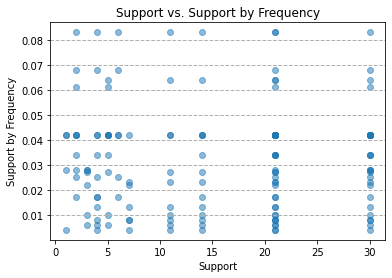

In [11]:
x = [mapping.target.supp for mapping in mappings]
y = [mapping.target.supp_freq for mapping in mappings]

# Plot
plt.scatter(x, y, alpha=0.5)
plt.title('Support vs. Support by Frequency')
plt.xlabel('Support')
plt.ylabel('Support by Frequency')
plt.grid('on', axis='y', linestyle='--', linewidth=1)
#plt.savefig("support_vs_supp_freq.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Plot Support vs. Expressiveness

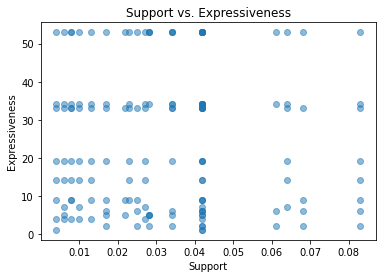

In [12]:
x = [mapping.target.supp_freq for mapping in mappings]
y = [mapping.target.expr for mapping in mappings]

# Plot
plt.scatter(x, y, alpha=0.5)
plt.title('Support vs. Expressiveness')
plt.xlabel('Support')
plt.ylabel('Expressiveness')
plt.show()

## Global

Complextiy Reduction

In [13]:
ca = mhelper.get_abstraction_goals(mappings)
cla = mhelper.get_abstractable_concepts(mappings)
cl = mhelper.get_low_level_concepts(ll_concepts)
clna = mhelper.get_not_abstractable_concepts(ll_concepts, mappings)

In [14]:
cr = m.complexity_reduction(ca, cla)
print(cr)

0.233


Total Complexity Reducion

In [15]:
ctr = m.complexity_reduction_total(ca, clna, cl)
print(ctr)

0.233


# Contraints

## Support

Try different configurations for support contraints:

In [21]:
mappings2 = deepcopy(mappings)
len(mappings2)

supp = range(0, 25, 5)
result = []

for s in supp:
    filtered_mapping = abshelper.filter_abstraction_candidates(mappings2, 100, s)
    #print(len(filtered_mapping))

    ca = mhelper.get_abstraction_goals(filtered_mapping)
    cla = mhelper.get_abstractable_concepts(filtered_mapping)
    cl = mhelper.get_low_level_concepts(ll_concepts)
    clna = mhelper.get_not_abstractable_concepts(ll_concepts, filtered_mapping)

    cr = m.complexity_reduction(ca, cla)
    ctr = m.complexity_reduction_total(ca, clna, cl)

    result.append((cr, ctr, len(ca)))
        
print(result)

[(0.233, 0.233, 23), (0.767, 0.767, 7), (0.833, 0.833, 5), (0.9, 0.9, 3), (0.9, 0.9, 3)]


## Dist

## Support & Dist

In [22]:
mappings2 = deepcopy(mappings)
len(mappings2)

dist = range(1, 4, 1)
supp = range(0, 25, 5)
result = []

leaf_paths = abshelper.get_leaf_paths(connector)

for d in dist:
    for s in supp:
        filtered_mappings = abshelper.filter_abstraction_candidates(mappings2, d, s)
        
        chosen_mappings = abshelper.select_mapping(filtered_mappings, connector, leaf_paths)
        
        ca = mhelper.get_abstraction_goals(chosen_mappings)
        cla = mhelper.get_abstractable_concepts(chosen_mappings)
        cl = mhelper.get_low_level_concepts(ll_concepts)
        clna = mhelper.get_not_abstractable_concepts(ll_concepts, chosen_mappings)
        
        cr = m.complexity_reduction(ca, cla)
        ctr = m.complexity_reduction_total(ca, clna, cl)
        
        result.append((cr, ctr, len(ca), d, s))
        
print(result)

[(0.367, 0.367, 19, 1, 0), (0.286, 0.067, 5, 1, 5), (0.25, 0.033, 3, 1, 10), (0.0, 0.0, 2, 1, 15), (0.0, 0.0, 2, 1, 20), (0.367, 0.367, 19, 2, 0), (0.65, 0.433, 7, 2, 5), (0.737, 0.467, 5, 2, 10), (0.727, 0.267, 3, 2, 15), (0.727, 0.267, 3, 2, 20), (0.367, 0.367, 19, 3, 0), (0.767, 0.767, 7, 3, 5), (0.821, 0.767, 5, 3, 10), (0.85, 0.567, 3, 3, 15), (0.85, 0.567, 3, 3, 20)]


In [23]:
old_res = [(0.367, 0.367, 19, 1, 0), (0.286, 0.067, 5, 1, 5), (0.25, 0.033, 3, 1, 10), (0.0, 0.0, 2, 1, 15), (0.0, 0.0, 2, 1, 20), (0.367, 0.367, 19, 2, 0), (0.65, 0.433, 7, 2, 5), (0.737, 0.467, 5, 2, 10), (0.727, 0.267, 3, 2, 15), (0.727, 0.267, 3, 2, 20), (0.367, 0.367, 19, 3, 0), (0.767, 0.767, 7, 3, 5), (0.821, 0.767, 5, 3, 10), (0.85, 0.567, 3, 3, 15), (0.85, 0.567, 3, 3, 20)]
new_res = [(0.367, 0.367, 19, 1, 0), (0.286, 0.067, 5, 1, 5), (0.25, 0.033, 3, 1, 10), (0.0, 0.0, 2, 1, 15), (0.0, 0.0, 2, 1, 20), (0.367, 0.367, 19, 2, 0), (0.65, 0.433, 7, 2, 5), (0.737, 0.467, 5, 2, 10), (0.727, 0.267, 3, 2, 15), (0.727, 0.267, 3, 2, 20), (0.367, 0.367, 19, 3, 0), (0.767, 0.767, 7, 3, 5), (0.821, 0.767, 5, 3, 10), (0.85, 0.567, 3, 3, 15), (0.85, 0.567, 3, 3, 20)]

print(old_res == result)

True


### Visualization

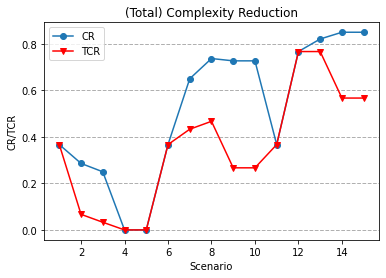

In [24]:
scenario = range(1, len(result) + 1)
cr = [res[0] for res in result]
tcr = [res[1] for res in result]

# Plot
plt.plot(scenario, cr, marker='o', label='CR')
plt.plot(scenario, tcr, color='red', marker='v', label='TCR')
plt.title('(Total) Complexity Reduction')
plt.xlabel('Scenario')
plt.ylabel('CR/TCR')
plt.grid('on', axis='y', linestyle='--', linewidth=1)
plt.legend()
#plt.savefig("scenario_1.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Discovery

In [26]:
mappings2 = deepcopy(mappings)
len(mappings2)

dist = 3
supp = 10

leaf_paths = abshelper.get_leaf_paths(connector)

filtered_mappings = abshelper.filter_abstraction_candidates(mappings2, dist, supp)

chosen_mappings = abshelper.select_mapping(filtered_mappings, connector, leaf_paths)

ca = mhelper.get_abstraction_goals(chosen_mappings)
cla = mhelper.get_abstractable_concepts(chosen_mappings)
cl = mhelper.get_low_level_concepts(ll_concepts)
clna = mhelper.get_not_abstractable_concepts(ll_concepts, chosen_mappings)

cr = m.complexity_reduction(ca, cla)
ctr = m.complexity_reduction_total(ca, clna, cl)

print(cr, ctr)

0.821 0.767


Replace Events in Log based in Mappings

In [27]:
log = xes_importer.apply(log_file)

In [28]:
new_log = helper.enhance_event_labels(log, event_to_con_mapping, chosen_mappings)

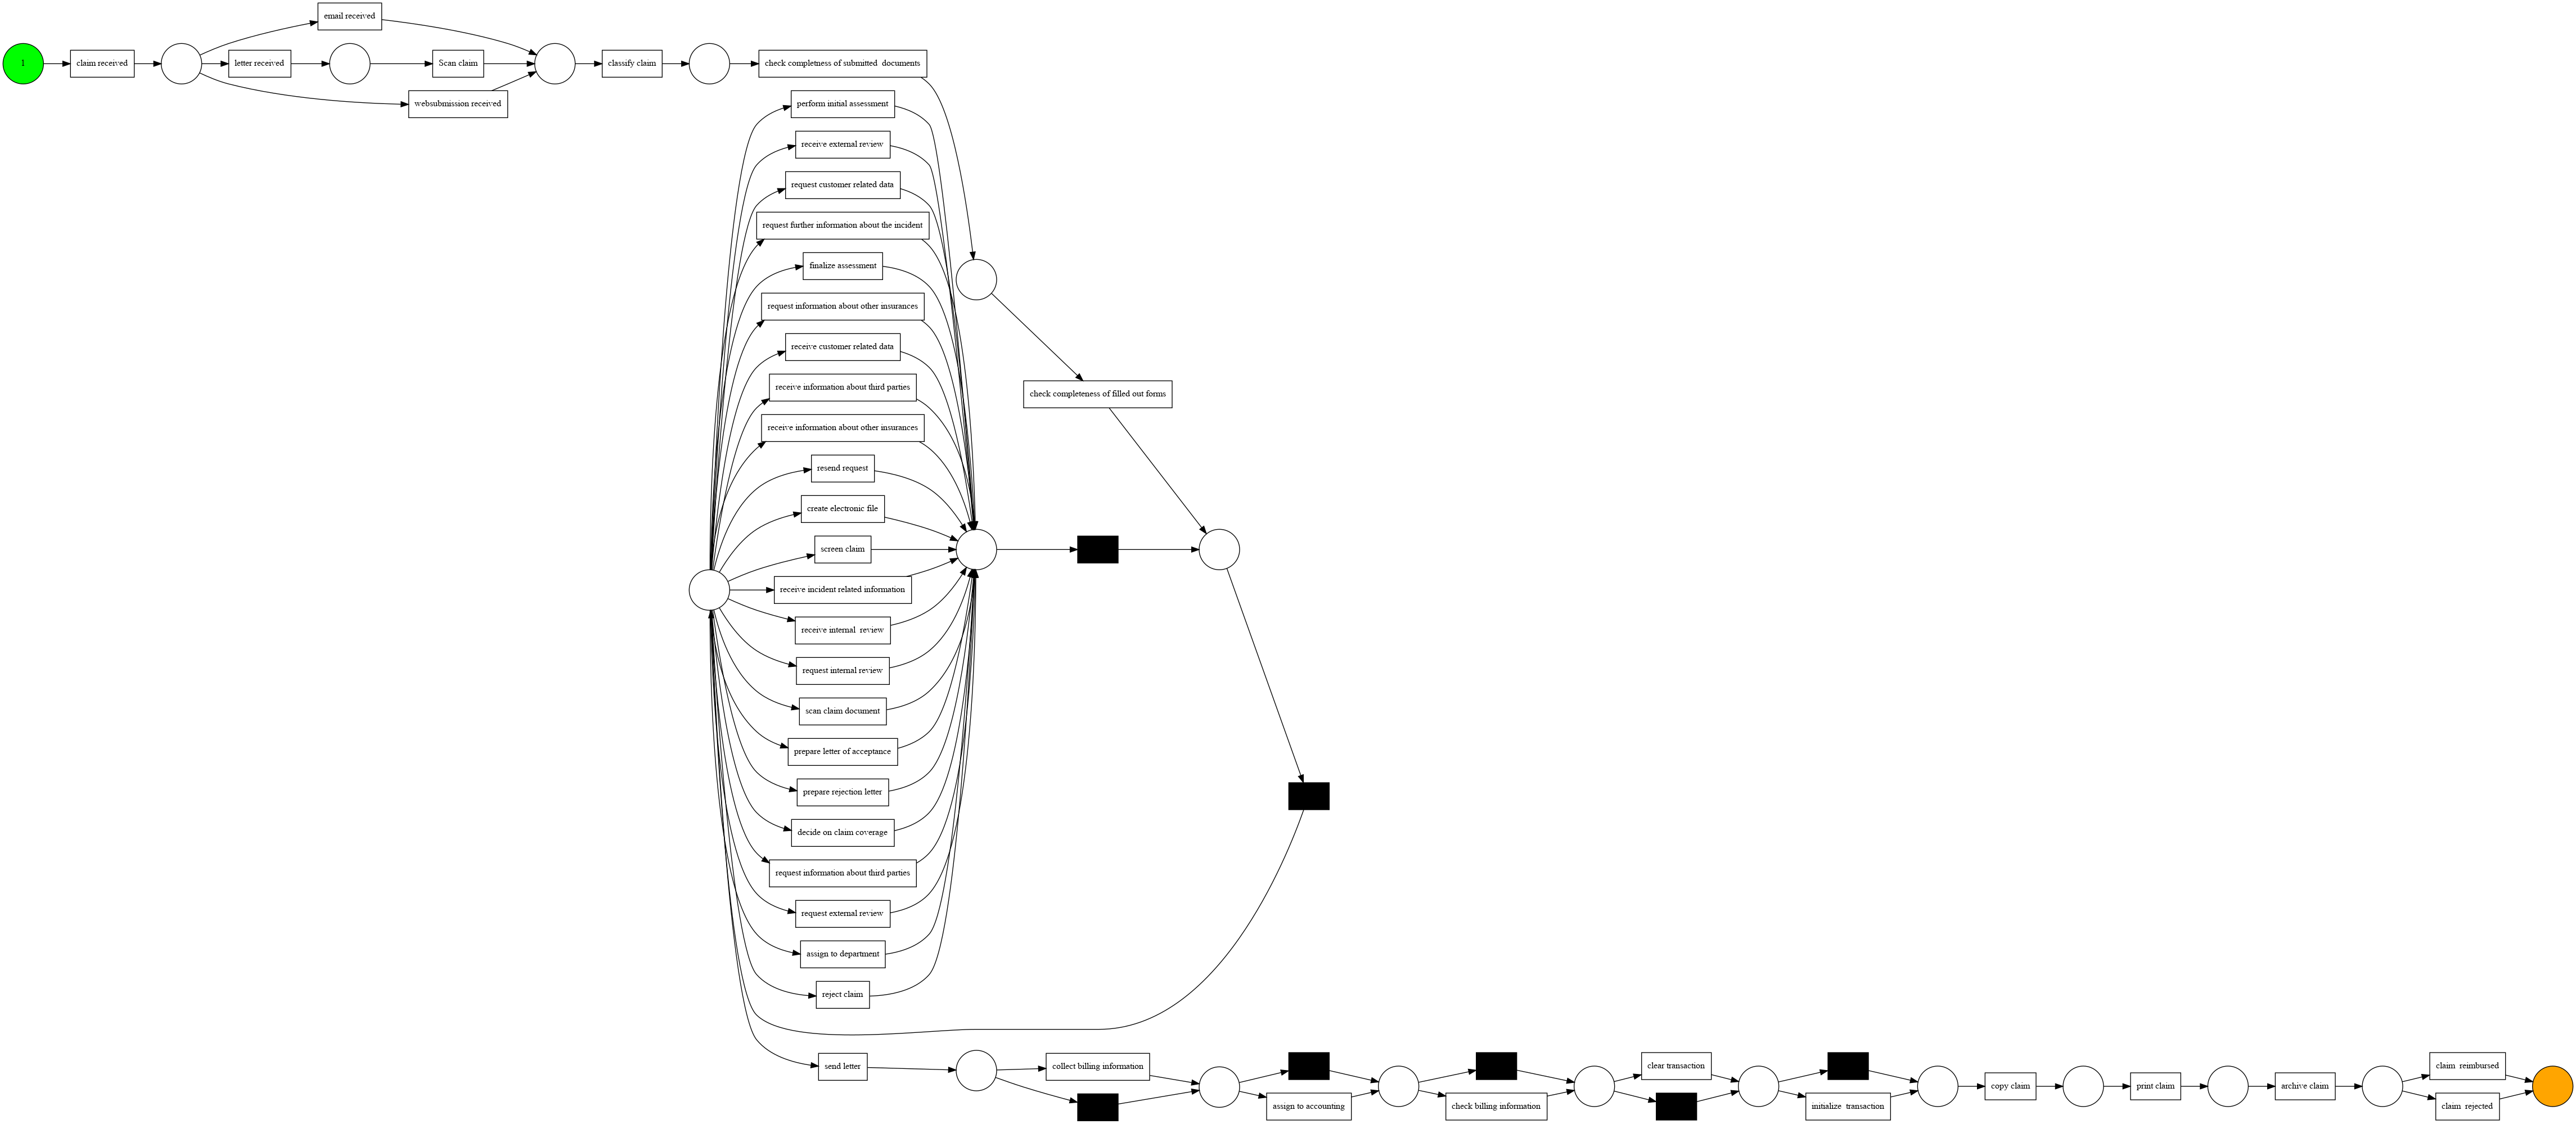

In [29]:
net, initial_marking, final_marking = inductive_miner.apply(log)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

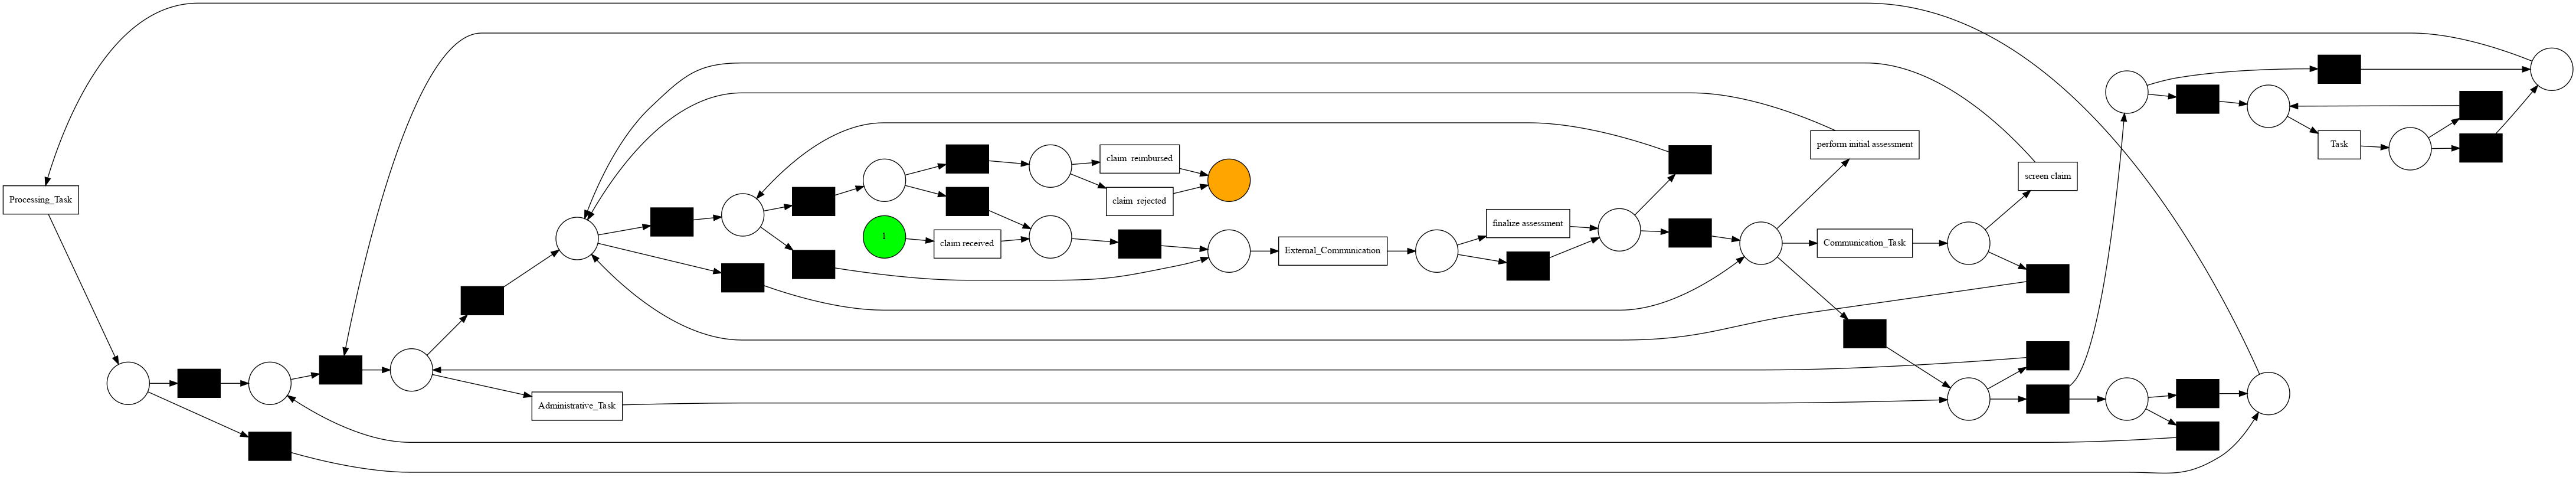

In [30]:
net, initial_marking, final_marking = inductive_miner.apply(new_log)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)